In [ ]:
# This reads in some LMIR frames I took to test for FPC/SPC slop and hysteresis

# Created 2019 Feb 17 by E.S.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numpy.ma as ma
import os.path
from scipy import misc, signal, ndimage
from astropy.io import fits
from matplotlib.colors import LogNorm
#% matplotlib inline
% matplotlib qt

from astrom_lmircam_soln import *
from astrom_lmircam_soln import find_pinhole_centroids
import photutils
from photutils import DAOStarFinder

In [ ]:
'''
UT Date 190217

med_dark-- frames 11-15: dark
med_016_020-- 16-20: baseline

med_021_025-- 21-25: FPC (top PSF) tilted to the right by 0.10" asec (i.e., +0.10")
med_026_030-- 26-30: another step like the above
med_031_035-- 31-35: another step like the above
med_036_040-- 36-40: FPC (top PSF) tilted to the left by 0.10" asec (i.e., -0.10")
med_041_045-- 41-45: another step like the above
med_046_050-- 46-50: another step like the above (should be at starting point, corresponding to frames 16-20)

UT Date 190218

med_190218_006_010-- 6-10: FPC (top PSF) tipped up by 0.10" asec (i.e., +0.10")
med_190218_011_015-- 11-15: another step like the above
med_190218_016_020-- 16-20: another step like the above
med_190218_021_025-- 21-25: FPC (top PSF) tipped down by 0.10" asec (i.e., -0.10")
med_190218_026_030-- 26-30: another step like the above
med_190218_031_035-- 31-35: another step like the above (should be at starting point, corresponding to frames 190217 46-50)

med_190218_036_040-- 36-40: SPC tilt to the right 0.50" (after 0.10" steps)
med_190218_041_045-- 41-45: moved back (should be at starting point, corresponding to frames 31-35)
med_190218_046_050-- 46-50: SPC tipped down 0.1"
med_190218_051_055-- 51-55: SPC tipped up 0.1" (should be at starting point, corresponding to frames 41-45)

med_190218_056_060-- 56-60: SPC translation stage moved 8200 -> 8199.90 um
med_190218_061_065-- 61-65: 8199.90 -> 8189.90 um
med_190218_066_070-- 66-70: 8189.90 -> 8200 um
med_190218_071_075-- 71-75: after SPC has shut down

med_190218_076_080-- 76-80: baseline for small FPC TT
med_190218_081_085-- 81-85: after tilt of 0.01"
med_190218_086_090-- 86-90: another step like the above
med_190218_091_095-- 91-95: after tilt of -0.02" (should be at starting point, corresponding to frames 76-80)
med_190218_096_100-- 96-100: after tip of +0.01"
med_190218_101_105-- 101-105: another step like the above
med_190218_106_110-- 106-110: after tip of -0.02" (should be at starting point, corresponding to frames 91-95)

med_190218_111_115-- 111-115: SPC translation stage moved 8200 -> 7200 um
med_190218_116_120-- 116-120: 7200 -> 4200 um
med_190218_121_125-- 121-125: 4200 -> 8200 um

In [3]:
stem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/tests/')

In [17]:
# make dark

image_cube = np.nan*np.ones((5,2048,2048))
frame_cube_counter = 0
for f in range(11,16):  # full dataset in HOSTS footprint: (4249,11497)

    filename_str = stem+'190217/lm_190217_'+str("{:0>6d}".format(f))+'.fits'
    
    if os.path.isfile(filename_str): # if FITS file exists in the first place
    
        image, header = fits.getdata(filename_str,0,header=True) 
        
        image_cube[frame_cube_counter,:,:] = image[0]
        
        frame_cube_counter += 1
        
med_dark = np.median(image_cube, axis=0)

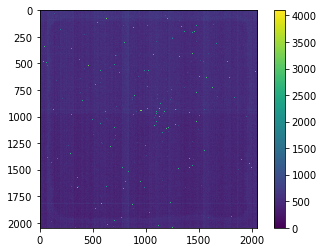

In [18]:
plt.imshow(image_cube[4,:,:])
plt.colorbar()
plt.show()

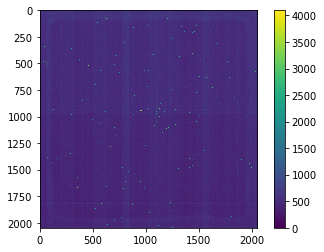

In [19]:
plt.imshow(med_dark)
plt.colorbar()
plt.show()

In [54]:
# make medians and save

image_cube = np.nan*np.ones((5,2048,2048))
frame_cube_counter = 0

start_frame_num = 121
stop_frame_num = 125
date_string = '190218'

for f in range(start_frame_num,stop_frame_num+1):  # full dataset in HOSTS footprint: (4249,11497)

    filename_str = stem+date_string+'/lm_'+date_string+'_'+str("{:0>6d}".format(f))+'.fits'
    
    if os.path.isfile(filename_str): # if FITS file exists in the first place
    
        image, header = fits.getdata(filename_str,0,header=True) 
        
        image_cube[frame_cube_counter,:,:] = np.subtract(image[0],med_dark)
        
        frame_cube_counter += 1
        
med = np.median(image_cube, axis=0)
        
hdu = fits.PrimaryHDU(med)
hdulist = fits.HDUList([hdu])
hdu.writeto(stem + 'med_' + date_string + '_' + str("{:0>3d}".format(start_frame_num)) + '_' + 
            str("{:0>3d}".format(stop_frame_num)) + '.fits', clobber=True)

In [14]:
# for very small movements, subtract one frame from another and see if there is asymmetry in the subtraction

file_before_move = "med_190218_081_085.fits"
file_after_move = "med_190218_106_110.fits"

#file_before_move = "med_190218_021_025.fits"
#file_after_move = "med_190218_091_095.fits"

image_before, header = fits.getdata(stem + file_before_move,0,header=True)
image_after, header = fits.getdata(stem + file_after_move,0,header=True)

image_diff = np.subtract(image_after,image_before)

print(image_diff)

plt.imshow(image_diff, origin="lower", vmin=-10, vmax=10)
plt.show()

[[ 2.  1.  1. ... -1.  0.  1.]
 [-2.  1. -1. ...  0. -2.  1.]
 [ 0.  1.  2. ...  1.  0.  1.]
 ...
 [-1.  0. -1. ... -2. -1.  0.]
 [ 0.  1. -2. ...  0.  2. -1.]
 [ 0. -2. -2. ... -2. -2. -4.]]


In [ ]:
# centroid with 

print("Finding star positions in dither position "+str(ditherPos)+" ...")

    # read in image and header
    imageMedian, header = fits.getdata(calibrated_trapezium_data_stem+
                                       'step04_ditherMedians/median_dither_'+'%02i'%ditherPos+'.fits',
                                       0, header=True)
    
    keyName = "dither_pos_"+str(ditherPos)

    # find star locations; input parameters may need some find-tuning to get good results
    xCoordsAsterism, yCoordsAsterism = find_pinhole_centroids.find_psf_centers(imageMedian,20.,15000.) 
    star_coords_every_dither[keyName] = np.transpose([xCoordsAsterism, yCoordsAsterism])
    print(np.transpose([xCoordsAsterism,yCoordsAsterism]))
    print("Please check the plot and note true positives among the printed star positions. Close the plot to continue.")
    
    # plots for cross-checking found centroids with true stars (save plots manually as desired)
    plt.imshow(imageMedian, origin="lower")
plt.scatter(xCoordsAsterism, yCoordsAsterism)